<b><h1>Books Recommendation System

In [3]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [4]:
books = pd.read_csv(r"/content/Books.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
users = pd.read_csv(r"/content/Users.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
ratings = pd.read_csv(r"/content/Book-Ratings.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1', engine='python')

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (92316, 8)
Users Data:     (278177, 3)
Books-ratings:  (1022489, 3)


<b><h3>Dataset

<b><h3>Pre-processing

<b>Books Dataset Pre-processing

In [5]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [7]:
## Checking for null values
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0


In [8]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [9]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [10]:
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [11]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002., 2001., 1991., 1999., 2000., 1993., 1996., 1988., 2004.,
       1998., 1994., 2003., 1997., 1983., 1979., 1995., 1982., 1985.,
       1992., 1986., 1978., 1980., 1952., 1987., 1990., 1981., 1989.,
       1984.,    0., 1968., 1961., 1958., 1974., 1976., 1971., 1977.,
       1975., 1965., 1941., 1970., 1962., 1973., 1972., 1960., 1966.,
       1920., 1956., 1959., 1953., 1951., 1942., 1963., 1964., 1969.,
       1954., 1950., 1967., 2005., 1957., 1940., 1937., 1955., 1946.,
       1936., 1930., 2011., 1925., 1948., 1943., 1947., 1945., 1923.,
       2020., 1939., 1926., 1938., 2030., 1911., 1904., 1949., 1932.,
       1928., 1929., 1927., 1931., 1914., 2050., 1934., 1910.,   nan])

In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [14]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [15]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [16]:
## Converting year of publication in Numbers
# Keep only rows where Year-Of-Publication is digits
books_cleaned = books[books['Year-Of-Publication'].astype(str).str.isdigit()].copy()

# Convert the column to integers now
books_cleaned['Year-Of-Publication'] = books_cleaned['Year-Of-Publication'].astype(int)



In [17]:
# Handle potential mixed types by attempting conversion to numeric, coercing errors to NaN
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# Remove NaN values before sorting to avoid the TypeError
# Alternatively, fill NaN with a placeholder if needed for later steps
valid_years = books['Year-Of-Publication'].dropna().unique().tolist()

# Sort the valid years
print(sorted(valid_years))


[0.0, 1904.0, 1910.0, 1911.0, 1914.0, 1920.0, 1923.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1934.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2011.0, 2020.0, 2030.0, 2050.0]


In [18]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002.0]

In [19]:
books_cleaned.loc[books_cleaned['Year-Of-Publication'] >  2021, 'Year-Of-Publication'] = 2002
books_cleaned.loc[books_cleaned['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [20]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [21]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True)
books.reset_index(drop = True, inplace = True)

In [22]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92269 entries, 0 to 92268
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 92264 non-null  object 
 1   Book-Title           92265 non-null  object 
 2   Book-Author          92266 non-null  object 
 3   Year-Of-Publication  92267 non-null  float64
 4   Publisher            92268 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.5+ MB


In [23]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company


<b>Users Dataset Pre-processing

In [24]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [25]:
## Checking null values
print(users.isna().sum())

User-ID          0
Location         0
Age         110508
dtype: int64


In [26]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[np.float64(nan), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(48.0), np.float64(49.0), np.float64(50.0), np.float64(51.0), np.float64(52.0), np.float64(53.0), np.float64(54.0), np

In [27]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [28]:
mean = round(required['Age'].mean())
mean

35

In [29]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [30]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries
            state.append('other')
            count_no_state += 1
        else:
            state.append(list_[i][1].lower())

        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())

users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values
print(count_no_state)     #printing the states which didnt have any values

4649
16044


In [31]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [32]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278177 entries, 0 to 278176
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278177 non-null  int64 
 1   Age      278177 non-null  int64 
 2   City     278177 non-null  object
 3   State    278177 non-null  object
 4   Country  278177 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [33]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


<b>Books-Ratings Dataset Pre-processing

In [34]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [35]:
## Checking for null values
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


In [36]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [37]:
## checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [38]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [39]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist()
reg = "[^A-Za-z0-9]"
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [40]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [41]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [42]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022488 entries, 0 to 1022487
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1022488 non-null  int64 
 1   ISBN         1022488 non-null  object
 2   Book-Rating  1022488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 23.4+ MB


In [43]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<h3><b>Merging of all three Tables

<b>Merging Books, Users and Rating Tables in One

In [44]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647325 entries, 0 to 647324
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 647325 non-null  object 
 1   Book-Title           647325 non-null  object 
 2   Book-Author          647325 non-null  object 
 3   Year-Of-Publication  647325 non-null  float64
 4   Publisher            647325 non-null  object 
 5   User-ID              647325 non-null  int64  
 6   Book-Rating          647325 non-null  int64  
 7   Age                  647325 non-null  int64  
 8   City                 647325 non-null  object 
 9   State                647325 non-null  object 
 10  Country              647325 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 54.3+ MB


<b>Divide complete data on the basis of Implicit and Explicit ratings datasets

In [45]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(244044, 11)

In [46]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(403281, 11)

In [47]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,11676,8,35,other,other,other
2,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,67544,8,30,toronto,ontario,canada
3,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,116866,9,35,ottawa,other,other
4,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,123629,9,35,kingston,ontario,canada


<h3><b>Data Visualization

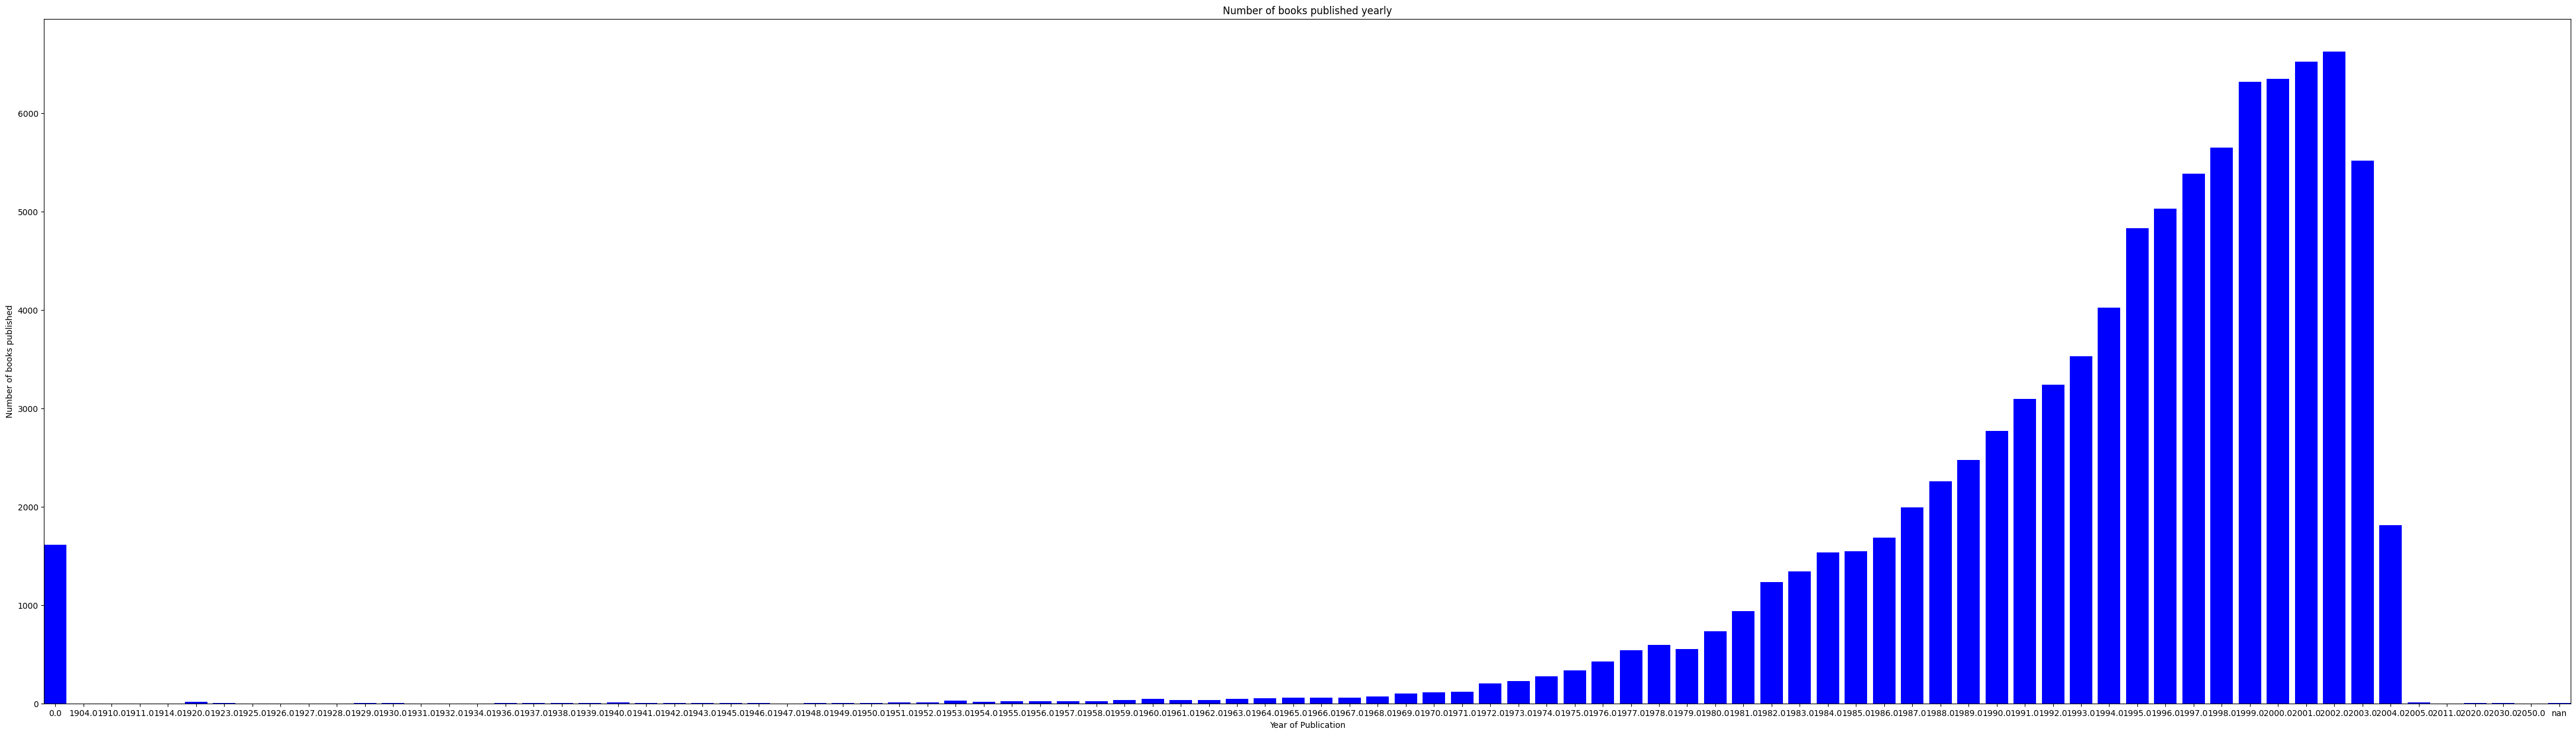

In [48]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

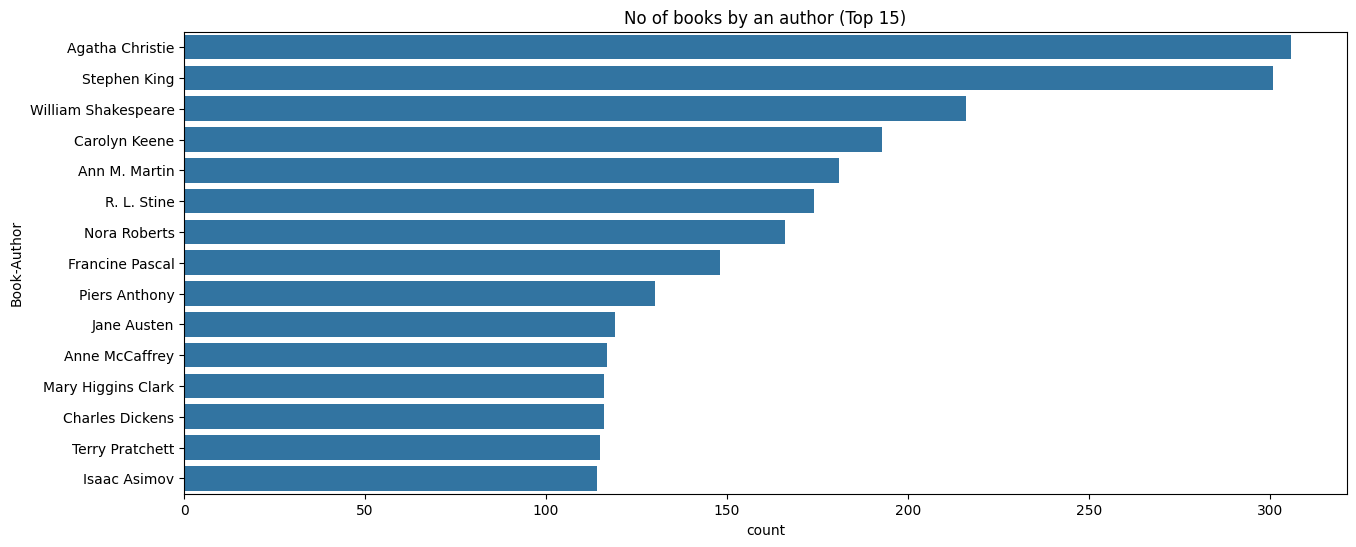

In [49]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

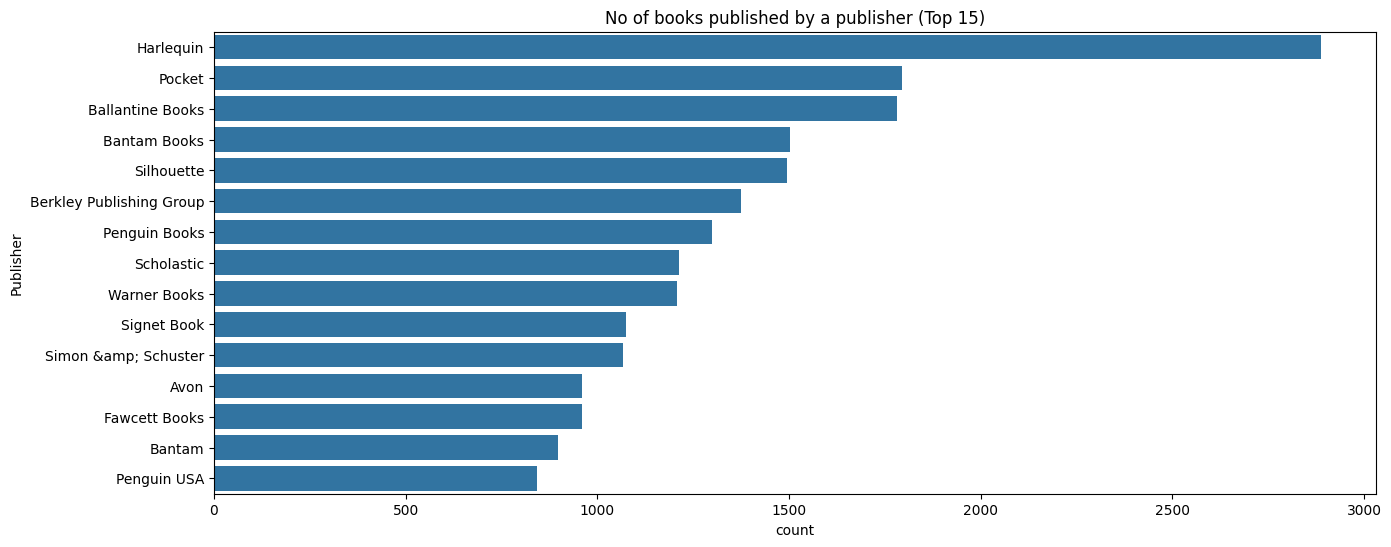

In [50]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

<Axes: xlabel='Book-Rating', ylabel='count'>

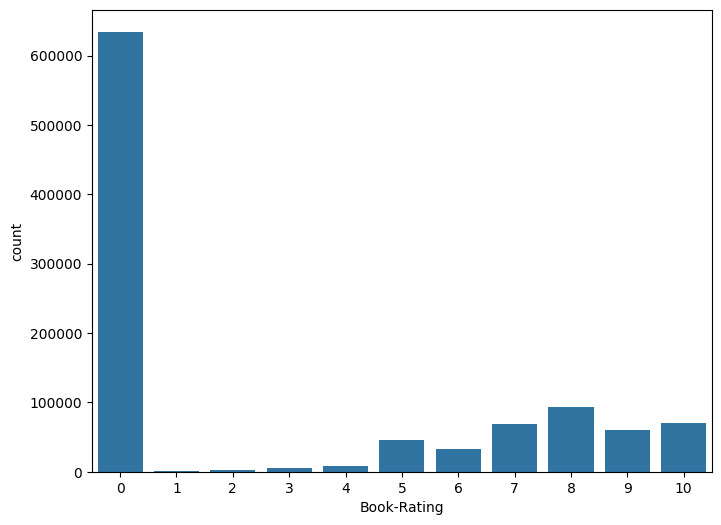

In [51]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

Text(0.5, 1.0, 'Explicit Ratings')

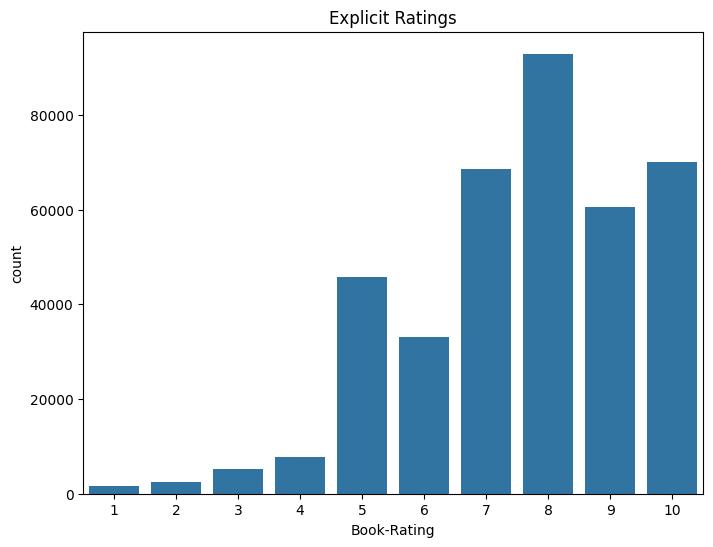

In [52]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

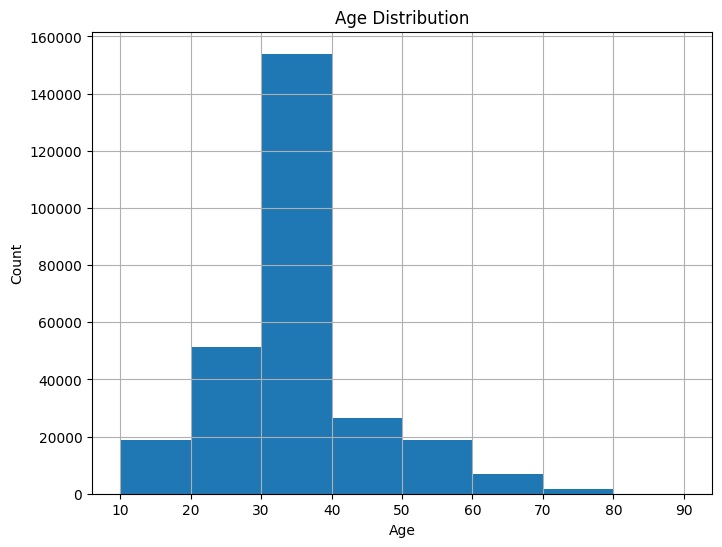

In [53]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

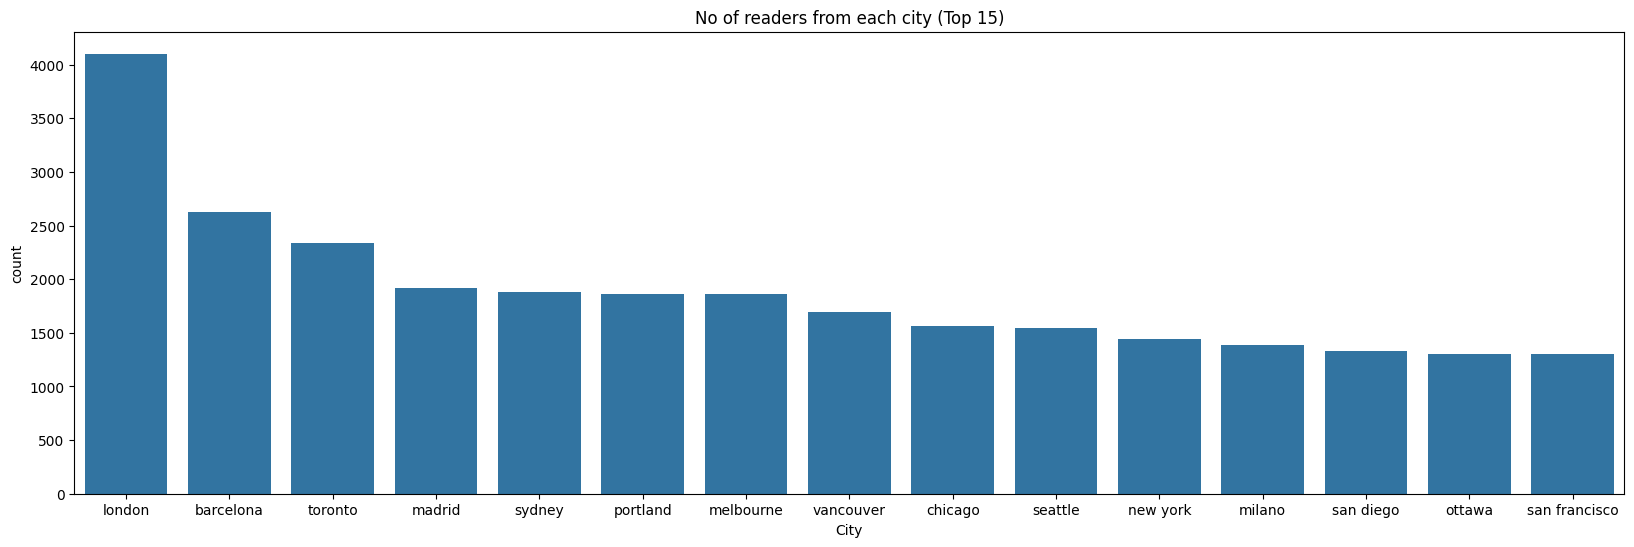

In [54]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

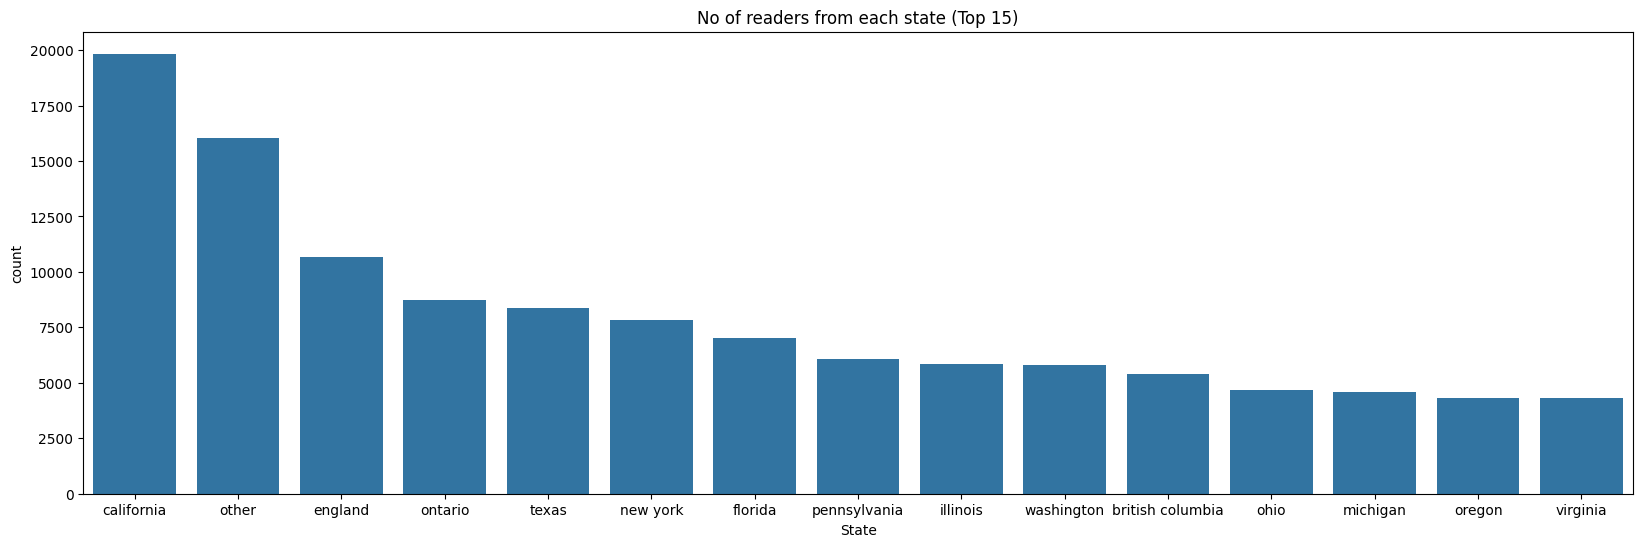

In [55]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

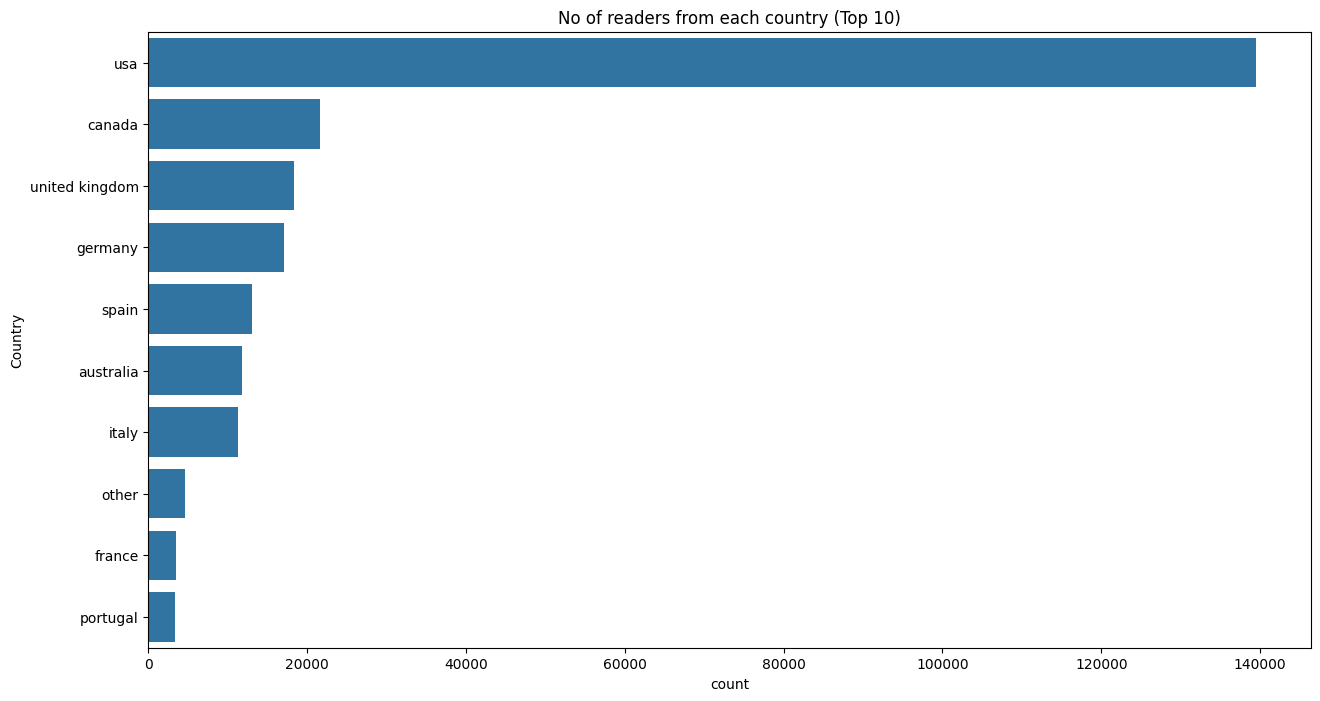

In [56]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

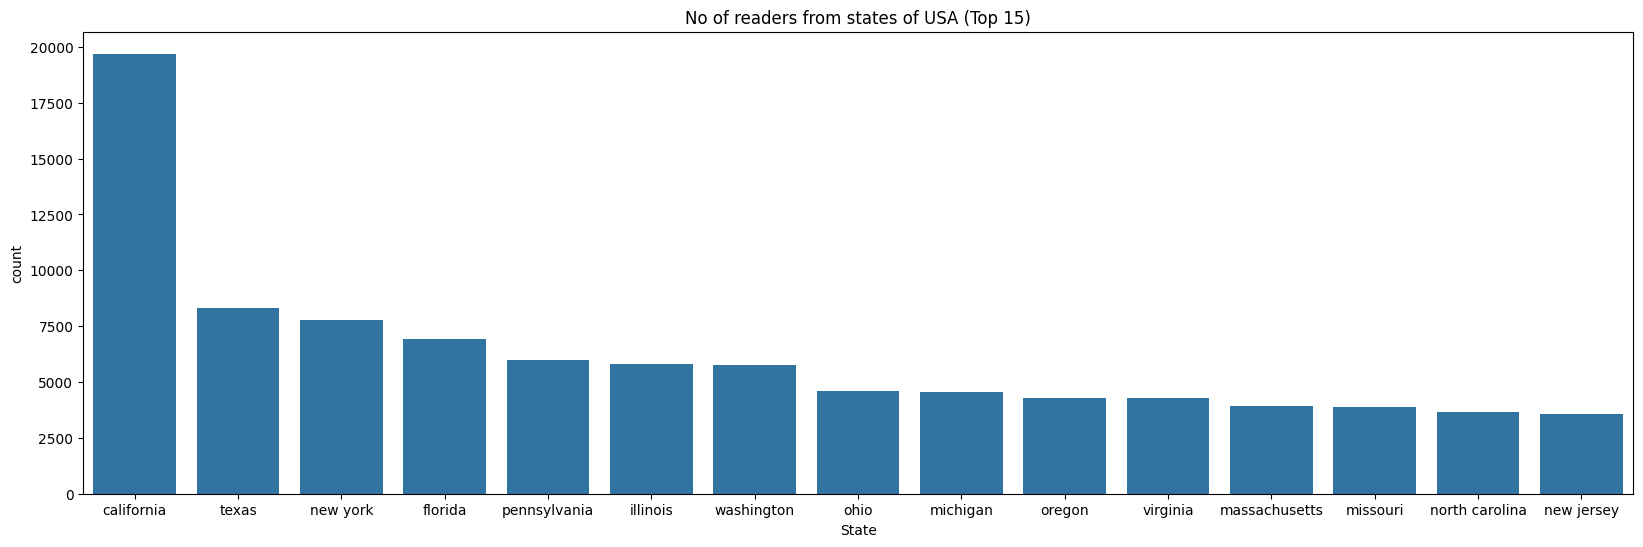

In [57]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

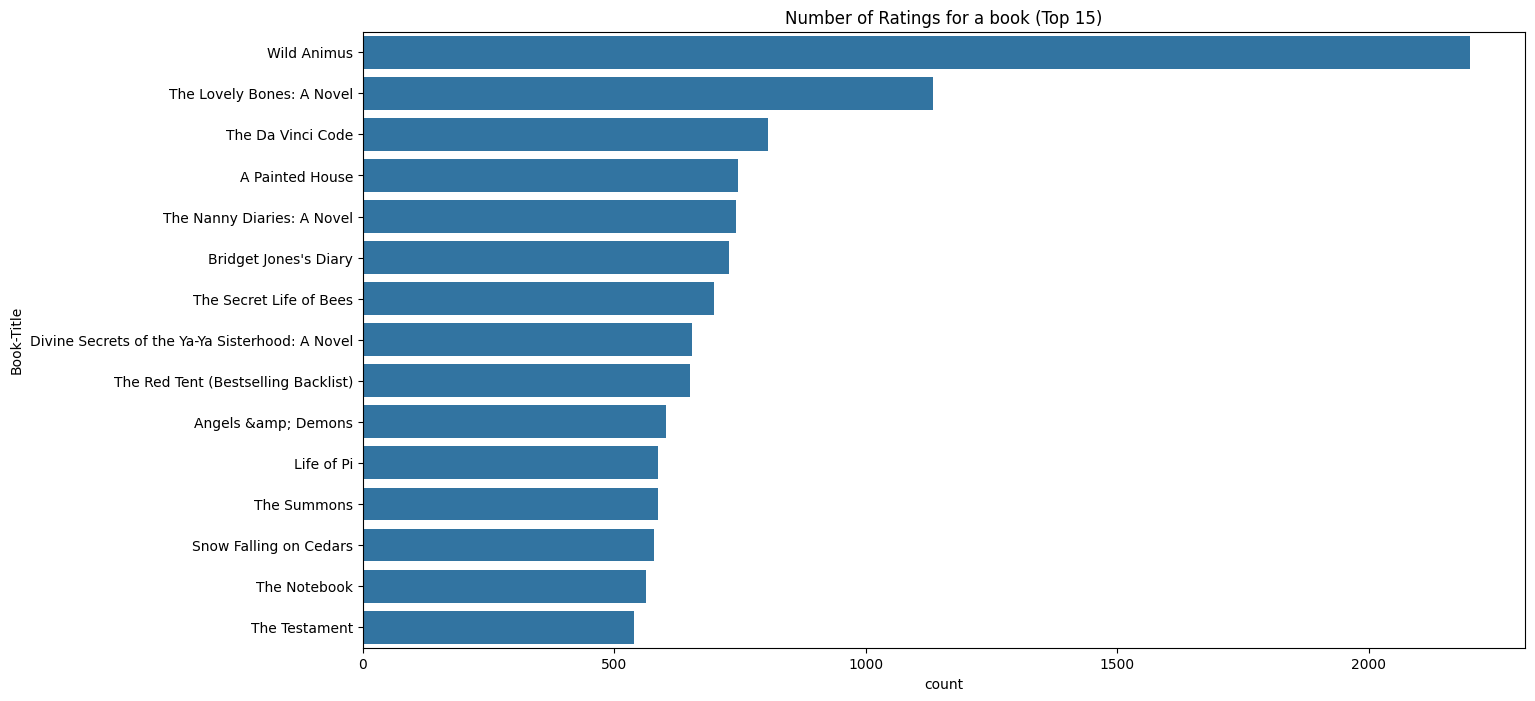

In [58]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

<h2><b>Recommendation Systems

In [59]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Enter a book name: the notebook
Enter number of books to recommend: 5


In [60]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        # Remove the 'on='ISBN'' argument as the merge is done on the index of 'data' which is 'ISBN'
        result = pd.merge(data, books, left_index = True, right_on='ISBN')
        return result
    return "Invalid number of books entered!!"

<h5><b> 1. Popularity Based (Top In whole collection)

In [61]:
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Top 5 Popular books are: 


,Book-Rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
407,618,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
26,509,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
747,442,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
521,342,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
1101,288,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial


<h5><b>2. Popularity Based (Top In a given place)

In [62]:
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [63]:
place = input("Enter the name of place: ")
data = search_unique_places(dataset1, place)

if isinstance(data, pd.DataFrame):
    data = popularity_based(data, number)

data

Enter the name of place: India


,Book-Rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
26,3,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
167,2,0486284735,Pride and Prejudice (Dover Thrift Editions),Jane Austen,1995.0,Dover Publications
169,2,0671047612,Skin And Bones,Franklin W. Dixon,2000.0,Aladdin
9652,2,8171670407,Inscrutable Americans,Mathur Anurag,1996.0,South Asia Books
4563,1,0140622500,Lady Chatterley's Lover (Penguin Popular Classics),D.H. Lawrence,1997.0,Penguin Books Ltd


<b><h5>3. Books by same author, publisher of given book name

In [64]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [65]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

In [66]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")

Invalid Book Name!!


In [67]:
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
# Remove the 'on='ISBN'' argument as the merge is done on the index of 'data' which is 'ISBN'
data = pd.merge(data, books, left_index=True, right_on='ISBN')

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
1258,0099771519,Memoirs of a Geisha Uk,Arthur Golden,0.0,Trafalgar Square
45630,038528120X,CATCH 22,JOSEPH HELLER,1904.0,Delta
45365,0938216120,A Guide to Hiking the Inner Canyon,Scott Thybony,1911.0,Gem Guides Book Co
8419,0684717603,The GREAT GATSBY (Scribner Classic),F. Scott Fritzgerald,1920.0,Scribner Paper Fiction
60256,0440745454,HOW TO EAT FRIED WORMS,THOMAS ROCKWELL,1923.0,Yearling
14695,0140185992,The Painted Veil (Penguin Twentieth Century Classics),W. Somerset Maugham,1925.0,Penguin Books
34938,0684718081,The Sun Also Rises,Ernest Hemingway,1926.0,Scribner Book Company
62797,0448089033,"The Secret of the Old Mill (The Hardy Boys Mystery Stories, Book 3)",Franklin W. Dixon,1927.0,Grosset &amp; Dunlap
53239,0060830484,Point Counter Point,Aldous Huxley,1928.0,Harpercollins
54051,0684717972,Farewell to Arms,Ernest Hemingway,1929.0,Charles Scribner's Sons


In [68]:
# Compute total ratings per book
df = pd.DataFrame(dataset1['Book-Title'].value_counts()).reset_index()
df.columns = ['Book-Title', 'Total-Ratings']

# Compute average rating per book
avg_ratings = dataset1.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_ratings.rename(columns={'Book-Rating': 'Average Rating'}, inplace=True)

# Merge total ratings and average ratings
df = pd.merge(df, avg_ratings, on='Book-Title')
print(dataset1.columns)


Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'User-ID', 'Book-Rating', 'Age', 'City', 'State', 'Country'],
      dtype='object')


<h5><b>4. Books popular Yearly

<b><h5>5. Average Weighted Ratings

In [70]:
## C - Mean vote across the whole
C = df['Average Rating'].mean()

## Minimum number of votes required to be in the chart
m = df['Total-Ratings'].quantile(0.90)

In [71]:
def weighted_rating(x, m=m, C=C):
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating
    return (v/(v+m) * R) + (m/(m+v) * C)

In [72]:
df = df.loc[df['Total-Ratings'] >= m]

df['score'] = df.apply(weighted_rating, axis=1)
df = df.sort_values('score', ascending=False)

print("Recommended Books:-\n")
df.head(number)

Recommended Books:-



,Book-Title,Total-Ratings,Average Rating,score
225,"The Return of the King (The Lord of the Rings, Part 3)",84,9.392857,9.229119
117,"The Two Towers (The Lord of the Rings, Part 2)",118,9.296610,9.183166
1929,Harry Potter and the Chamber of Secrets Postcard Book,20,9.850000,9.181390
30,Harry Potter and the Goblet of Fire (Book 4),213,9.140845,9.081805
1681,Calvin and Hobbes,22,9.636364,9.069298


<b><h5>6. Collaborative Filtering (User-Item Filtering)

Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)

In [73]:
print(dataset1.columns.tolist())
['Book Title', 'User-ID', 'Book-Rating']
# Use actual column name as printed above
book_col = 'Book-Title'  # change this based on your actual column name

# Compute total ratings per book
df = pd.DataFrame(dataset1[book_col].value_counts()).reset_index()
df.columns = [book_col, 'Total-Ratings']

# Compute average rating per book
avg_ratings = dataset1.groupby(book_col)['Book-Rating'].mean().reset_index()
avg_ratings.rename(columns={'Book-Rating': 'Average Rating'}, inplace=True)

# Merge total and average ratings
df = pd.merge(df, avg_ratings, on=book_col)


['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'User-ID', 'Book-Rating', 'Age', 'City', 'State', 'Country']


User - Item Collaborative Filtering

In [74]:
# Assuming df has Book-Title, Total-Ratings, and Average Rating
popular_book_titles = df[df['Total-Ratings'] > 100]['Book-Title']  # or any threshold you want

# Filter the original dataset1 for only those popular books
popular_book = dataset1[dataset1['Book-Title'].isin(popular_book_titles)]

testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [75]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [76]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)

    print("\nRECOMMENDATIONS:\n")

    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [77]:
bookName = "The Notebook"  # change this as needed

if bookName in dataset1['Book-Title'].values:
    isbn = dataset1[dataset1['Book-Title'] == bookName]['ISBN'].iloc[0]
    collaborative = getTopRecommandations(isbn)
else:
    print(f"'{bookName}' not found in the dataset.")

k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
The Notebook

RECOMMENDATIONS:

A Walk to Remember
The Rescue
Suzanne's Diary for Nicholas
The Last Time They Met : A Novel
Fahrenheit 451
Input Book:
The Notebook

RECOMMENDATIONS:

A Walk to Remember
The Rescue
Suzanne's Diary for Nicholas
The Last Time They Met : A Novel
Fahrenheit 451


<b><h5>7. Correlation Based

In [78]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [79]:
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.428291,2203
0316666343,8.161812,1134
0385504209,8.425339,795
0312195516,8.169591,651
0060928336,7.857639,648


In [80]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0446532452,The Wedding,Nicholas Sparks,2003.0,Warner Books
1,1551665301,Book Club,Mary Alice Monroe,1999.0,Mira
2,0553096079,Reba: My Story,Reba McEntire,1994.0,Bantam
3,1878424114,The Seven Spiritual Laws of Success: A Practical Guide to the Fulfillment of Your Dreams (based on Creating Affluence),Deepak Chopra,1995.0,New World Library
4,0882402323,Alaska Bear Tales,Larry Kaniut,1983.0,Alaska Northwest Books


<h5><b>8. Nearest Neighbours Based

In [81]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [82]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

A Walk to Remember
Message in a Bottle
The Rescue
Nights in Rodanthe
The Wedding


<h5><b>9. Content Based

In [83]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(251, 3)

In [84]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(251, 928)

In [86]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(251, 251)

In [87]:
# Prepare popular_book as before
popular_titles = df[df['Total-Ratings'] > 100]['Book-Title']
popular_book = dataset1[dataset1['Book-Title'].isin(popular_titles)][['ISBN', 'Book-Title', 'Book-Rating']]
popular_book = popular_book.drop_duplicates(subset='Book-Title').reset_index(drop=True)

# Get ISBN for bookName
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop=True).iloc[0]['ISBN']

# Get positional index for this ISBN in popular_book
label_idx_list = popular_book.index[popular_book['ISBN'] == isbn].tolist()
if not label_idx_list:
    raise ValueError(f"ISBN {isbn} for book '{bookName}' not found in popular_book.")
label_idx = label_idx_list[0]
pos_idx = popular_book.index.get_loc(label_idx)

# Get similarity indices sorted descending
similar_indices = cosine_similarities[pos_idx].argsort()[::-1]

similar_items = []
content = []

max_len = len(popular_book)
for i in similar_indices:
    # Check index bounds before accessing
    if i >= max_len:
        continue
    book_title = popular_book['Book-Title'].iloc[i]
    if (book_title != bookName and book_title not in similar_items and len(similar_items) < number):
        similar_items.append(book_title)
        content.append(book_title)

print("Recommended Books:\n")
for book in similar_items:
    print(book)


Recommended Books:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Seven Up (A Stephanie Plum Novel)
The Horse Whisperer
Q Is for Quarry
Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)


<b><h5>10. Hybrid Approach (Content+Collaborative) Using percentile

In [88]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(bookName)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

The Notebook

Recommended Books:

A Walk to Remember
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
The Rescue
Seven Up (A Stephanie Plum Novel)
Suzanne's Diary for Nicholas


In [89]:
pip install gradio


In [90]:
import pandas as pd

# Preview a few rows to debug the structure
books_path = "/content/Books.csv"

try:
    books_preview = pd.read_csv(
        books_path,
        encoding='latin1',
        sep=';',
        quotechar='"',
        engine='python',  # More tolerant to inconsistencies
        nrows=20  # Read just 20 rows
    )
    print(books_preview.head())
except Exception as e:
    print("Error while reading preview:", e)


         ISBN  \
0  0195153448   
1  0002005018   
2  0060973129   
3  0374157065   
4  0393045218   

                                                                                           Book-Title  \
0                                                                                 Classical Mythology   
1                                                                                        Clara Callan   
2                                                                                Decision in Normandy   
3  Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It   
4                                                                              The Mummies of Urumchi   

            Book-Author  Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                 2002     Oxford University Press   
1  Richard Bruce Wright                 2001       HarperFlamingo Canada   
2          Carlo D'Este               

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
books = pd.read_csv(
    "/content/Books.csv",
    encoding='latin1',
    sep=';',
    quotechar='"',
    engine='python',
    on_bad_lines='skip'  # <--- skip problematic lines
)
users = pd.read_csv("/content/Users.csv", encoding='latin1', sep=';', quotechar='"', engine='python', on_bad_lines='skip')
ratings = pd.read_csv("/content/Book-Ratings.csv", encoding='latin1', sep=';', quotechar='"', engine='python', on_bad_lines='skip')



In [93]:
import pandas as pd
import gradio as gr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load datasets
books = pd.read_csv("Books.csv", sep=';', encoding='latin1', on_bad_lines='skip', low_memory=False)
ratings = pd.read_csv("Book-Ratings.csv", sep=';', encoding='latin1', on_bad_lines='skip', low_memory=False)

# Merge ratings and books to get book popularity
ratings_count = ratings.groupby('ISBN').count()['Book-Rating'].reset_index()
rated_books = pd.merge(books, ratings_count, on='ISBN')
rated_books.rename(columns={'Book-Rating': 'RatingCount'}, inplace=True)

# Drop duplicates and clean
rated_books.drop_duplicates(subset='Book-Title', inplace=True)
rated_books['Book-Title'].fillna('', inplace=True)
rated_books['Book-Author'].fillna('Unknown', inplace=True)
rated_books['Publisher'].fillna('Unknown', inplace=True)
rated_books['Image-URL-L'].fillna('https://via.placeholder.com/150', inplace=True)
rated_books['content'] = rated_books['Book-Title'] + ' ' + rated_books['Book-Author'] + ' ' + rated_books['Publisher']

# Reduce data to avoid memory overload
rated_books = rated_books.head(5000)

# Get max rating count
max_rating_count = rated_books['RatingCount'].max()

# Recommendation logic
def recommend_by_genre(genre, rating_threshold):
    if genre is None or genre == "":
        return "<div style='color:red;'>Please select a genre first.</div>"

    genre_books = rated_books[
        (rated_books['content'].str.contains(genre, case=False, na=False)) &
        (rated_books['RatingCount'] >= rating_threshold)
    ]
    top_books = genre_books.sort_values(by='RatingCount', ascending=False).head(10)
    recommendations = []
    for _, row in top_books.iterrows():
        card = f"""
        <div class='card'>
            <img src="{row['Image-URL-L']}" class='cover'/>
            <div class='info'>
                <h4>{row['Book-Title']}</h4>
                <p>by {row['Book-Author']}</p>
                <p class='rating'>Rating Count: {row['RatingCount']}</p>
            </div>
        </div>
        """
        recommendations.append(card)
    return f"<div class='card-container'>{''.join(recommendations)}</div>"

# Gradio Interface with enhanced CSS
demo = gr.Blocks(css="""
    body {
        font-family: 'Segoe UI', sans-serif;
        background: url("") no-repeat center center fixed;
background-size: cover;

        margin: 0;
        padding: 0;
        color: #f5f5f5;
    }
    .gradio-container {
        padding: 30px;
        background: rgba(20, 20, 20, 0.85);
        border-radius: 16px;
        box-shadow: 0 0 25px rgba(0,0,0,0.4);
    }
    .menu-bar {
        display: flex;
        gap: 20px;
        padding: 15px;
        justify-content: center;
        background: rgba(255,255,255,0.1);
        color: #ffffff;
        font-size: 1.2em;
        border-radius: 12px;
        margin-bottom: 20px;
        flex-wrap: wrap;
    }
    .card-container {
        display: grid;
        grid-template-columns: repeat(auto-fill, minmax(220px, 1fr));
        gap: 16px;
        padding: 10px;
    }
    .card {
        background: #2e2e2e;
        border-radius: 12px;
        box-shadow: 0 4px 12px rgba(0,0,0,0.4);
        padding: 16px;
        text-align: center;
        color: #ffffff;
        transition: transform 0.3s ease;
    }
    .card:hover {
        transform: scale(1.05);
    }
    .cover {
        width: 100%;
        height: auto;
        border-radius: 8px;
        box-shadow: 0 2px 8px rgba(0,0,0,0.5);
    }
    .info {
        margin-top: 10px;
    }
    .rating {
        color: #f39c12;
        font-weight: bold;
    }
""")

with demo:
    gr.Markdown("""# Book Recommendation Sytem""")

    with gr.Row(elem_classes="menu-bar"):
        with gr.Column():
            genre_dropdown = gr.Dropdown(
                choices=["", 'Poetry', 'Drama', 'Science', 'Romance', 'Mystery', 'History'],
                label="Choose Genre",
                interactive=True
            )
            rating_slider = gr.Number(
                minimum=0,
                maximum=max_rating_count,
                value=10,
                label="Minimum Rating Count",
                interactive=True
            )

    html_output = gr.HTML()

    genre_dropdown.change(fn=recommend_by_genre, inputs=[genre_dropdown, rating_slider], outputs=html_output)
    rating_slider.change(fn=recommend_by_genre, inputs=[genre_dropdown, rating_slider], outputs=html_output)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9219f9df3fb6ee83e0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
